In [17]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import seaborn as sns

In [2]:
#Importing my dataset
df = pd.read_csv('fake_currency_data.csv')
#Use head, tail, and info to show the basic information about the dataset
df.head()

,Country,Denomination,Counterfeit,SerialNumber,SecurityFeatures,Weight,Length,Width,Thickness
0,USA,$100,1,25973198,Hologram,1.731759,130.243185,66.537999,0.098488
1,USA,$20,1,95903230,Security Thread,1.002179,152.596364,76.135834,0.094119
2,EU,€10,0,82937914,Hologram,2.306713,152.857126,66.772442,0.061393
3,USA,€20,1,23612989,Microprint,1.366965,143.133672,78.377052,0.053114
4,EU,€20,1,56025342,Watermark,1.796075,129.664777,75.916093,0.051438


In [3]:
df.describe()

,Counterfeit,SerialNumber,Weight,Length,Width,Thickness
count,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.499391,5.502259e+07,1.649766,140.020542,70.003944,0.074995
std,0.500000,2.598490e+07,0.490712,11.544293,5.772709,0.014442
min,0.000000,1.000015e+07,0.800003,120.000073,60.000005,0.050000
25%,0.000000,3.249784e+07,1.224855,130.034878,64.999762,0.062487
50%,0.000000,5.506594e+07,1.649137,140.032496,70.008440,0.074992
75%,1.000000,7.751115e+07,2.074540,150.022309,75.006372,0.087499
max,1.000000,9.999994e+07,2.499999,159.999961,79.999983,0.100000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Country           1000000 non-null  object 
 1   Denomination      1000000 non-null  object 
 2   Counterfeit       1000000 non-null  int64  
 3   SerialNumber      1000000 non-null  int64  
 4   SecurityFeatures  1000000 non-null  object 
 5   Weight            1000000 non-null  float64
 6   Length            1000000 non-null  float64
 7   Width             1000000 non-null  float64
 8   Thickness         1000000 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 68.7+ MB


In [5]:
df.isnull().sum()

Country             0
Denomination        0
Counterfeit         0
SerialNumber        0
SecurityFeatures    0
Weight              0
Length              0
Width               0
Thickness           0
dtype: int64

In [6]:
# Handle missing values (if any)
df = df.dropna()

# Handle outliers using Z-score
numerical_columns = ['Weight', 'Length', 'Width', 'Thickness']  # Replace with relevant numerical columns
z_scores = df[numerical_columns].apply(zscore)
df = df[(z_scores.abs() <= 3).all(axis=1)]

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


In [7]:
# Detect anomalies using Z-score
z_scores = df[numerical_columns].apply(zscore)
df['Statistical_Anomaly'] = (z_scores.abs() > 3).any(axis=1)


In [8]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
df['IsolationForest_Anomaly'] = isolation_forest.fit_predict(df[numerical_columns])

# Convert results to binary (1: anomaly, 0: normal)
df['IsolationForest_Anomaly'] = df['IsolationForest_Anomaly'].map({1: 0, -1: 1})


In [9]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(contamination=0.01, random_state=42)
df['IsolationForest_Anomaly'] = isolation_forest.fit_predict(df[numerical_columns])
df['IsolationForest_Anomaly'] = df['IsolationForest_Anomaly'].map({1: 0, -1: 1})


In [10]:
z_scores = df[numerical_columns].apply(zscore)
df['Statistical_Anomaly'] = (z_scores.abs() > 3).any(axis=1)


In [11]:
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df[f'{col}_Anomaly'] = ~df[col].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

df['IQR_Anomaly'] = df[[f'{col}_Anomaly' for col in numerical_columns]].any(axis=1)


Evaluation for Statistical_Anomaly:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67    500609
           1       0.00      0.00      0.00    499391

    accuracy                           0.50   1000000
   macro avg       0.25      0.50      0.33   1000000
weighted avg       0.25      0.50      0.33   1000000

Confusion Matrix:
[[500609      0]
 [499391      0]]
Evaluation for IsolationForest_Anomaly:
              precision    recall  f1-score   support

           0       0.50      0.99      0.66    500609
           1       0.49      0.01      0.02    499391

    accuracy                           0.50   1000000
   macro avg       0.50      0.50      0.34   1000000
weighted avg       0.50      0.50      0.34   1000000

Confusion Matrix:
[[495547   5062]
 [494453   4938]]


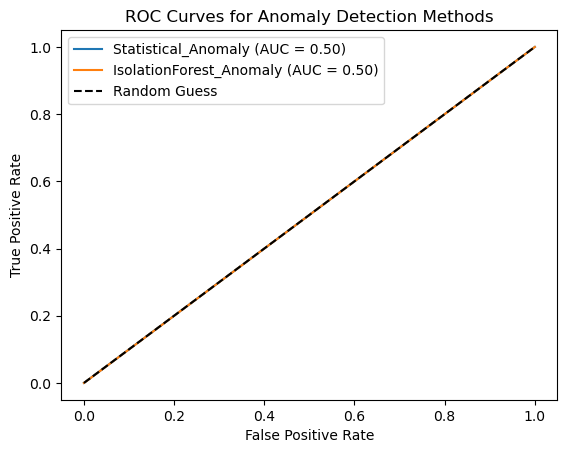

In [15]:
# Assuming "Counterfeit" is the ground truth for anomalies
ground_truth = df['Counterfeit']  # Replace 'Counterfeit' with the actual target column name

# Evaluate each method
for method in ['Statistical_Anomaly', 'IsolationForest_Anomaly']:
    print(f"Evaluation for {method}:")
    print(classification_report(ground_truth, df[method]))
    print("Confusion Matrix:")
    print(confusion_matrix(ground_truth, df[method]))

    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(ground_truth, df[method])
    auc_score = roc_auc_score(ground_truth, df[method])
    plt.plot(fpr, tpr, label=f"{method} (AUC = {auc_score:.2f})")

# Finalize and display the ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves for Anomaly Detection Methods')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


<Axes: xlabel='Weight', ylabel='Length'>

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


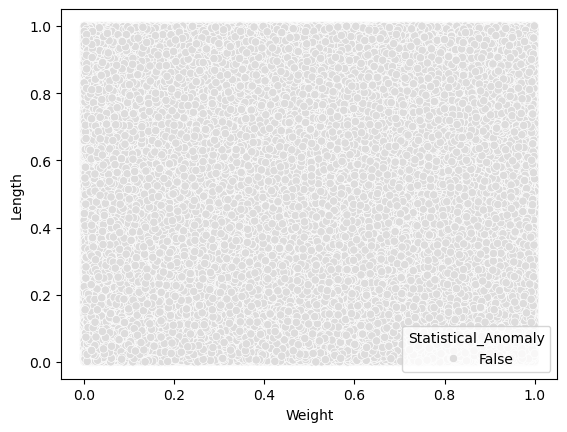

In [24]:
# Assuming your dataset has columns for the features you're interested in
sns.scatterplot(data=df, x='Weight', y='Length', hue='Statistical_Anomaly', palette='coolwarm')


In [25]:
print(df.columns)


Index(['Country', 'Denomination', 'Counterfeit', 'SerialNumber',
       'SecurityFeatures', 'Weight', 'Length', 'Width', 'Thickness',
       'Statistical_Anomaly', 'IsolationForest_Anomaly', 'Weight_Anomaly',
       'Length_Anomaly', 'Width_Anomaly', 'Thickness_Anomaly', 'IQR_Anomaly'],
      dtype='object')


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


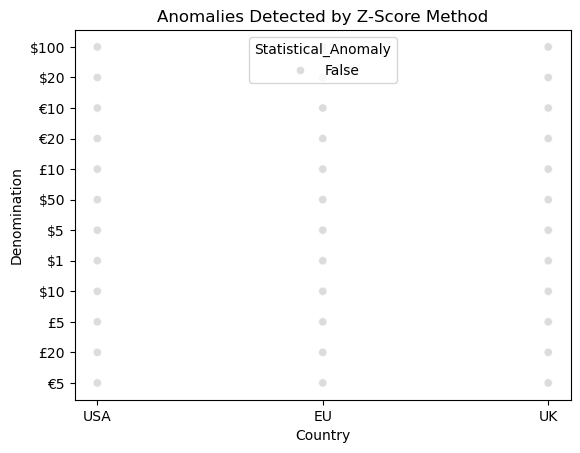

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


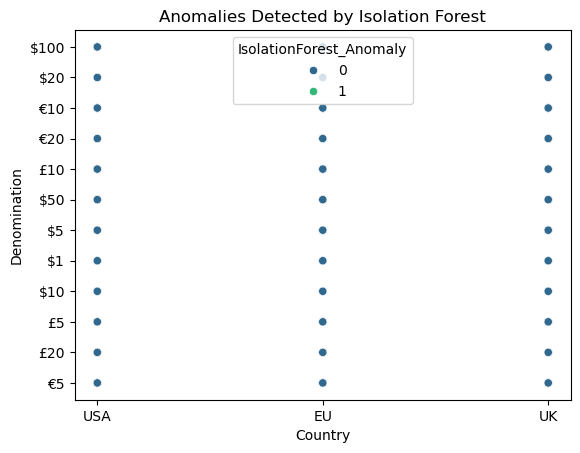

In [34]:
# Example for the first 2 numerical columns, adjust based on your data
sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue='Statistical_Anomaly', palette='coolwarm')
plt.title('Anomalies Detected by Z-Score Method')
plt.show()

sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue='IsolationForest_Anomaly', palette='viridis')
plt.title('Anomalies Detected by Isolation Forest')
plt.show()


In [38]:
# Count anomalies detected by each method
anomalies_count = df[['Statistical_Anomaly', 'IsolationForest_Anomaly']].sum()

print("Number of Anomalies Detected by Each Method:")
print(anomalies_count)

# Report findings
summary = {
    "Statistical Method": {
        "Precision": classification_report(ground_truth, df['Statistical_Anomaly'], output_dict=True)['1']['precision'],
        "Recall": classification_report(ground_truth, df['Statistical_Anomaly'], output_dict=True)['1']['recall'],
        "F1-Score": classification_report(ground_truth, df['Statistical_Anomaly'], output_dict=True)['1']['f1-score'],
    },
    "Isolation Forest": {
        "Precision": classification_report(ground_truth, df['IsolationForest_Anomaly'], output_dict=True)['1']['precision'],
        "Recall": classification_report(ground_truth, df['IsolationForest_Anomaly'], output_dict=True)['1']['recall'],
        "F1-Score": classification_report(ground_truth, df['IsolationForest_Anomaly'], output_dict=True)['1']['f1-score'],
    }
}

print("\nSummary of Detection Effectiveness:")
for method, metrics in summary.items():
    print(f"\n{method}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Number of Anomalies Detected by Each Method:
Statistical_Anomaly            0
IsolationForest_Anomaly    10000
dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa


Summary of Detection Effectiveness:

Statistical Method:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000

Isolation Forest:
  Precision: 0.4938
  Recall: 0.0099
  F1-Score: 0.0194
